In [29]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 90.8 MB/s eta 0:00:00


In [52]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import urllib.request
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [44]:
# download the data
url = f"https://downloads.psl.noaa.gov/Datasets/ghcncams/air.mon.mean.nc"
savename = url.split("/")[-1]
urllib.request.urlretrieve(url, savename)

('air.mon.mean.nc', <http.client.HTTPMessage at 0x7ef898f0d390>)

In [48]:
# load dataset
data = xr.open_dataset(savename)
TA = data["air"] - 273.15  # convert from kelvin to celsius
time = TA.time.sel(time=slice("1990", "2020")) # time slice to the selected time frame
TA = TA.sel(time=time)

# Step 1: compute global mean temperature (area-weighted and unweighted)

In [54]:
# define a function to compute the weighted mean
def weighted_mean(data):
    weights = np.cos(np.deg2rad(data.lat)) # calculate cosine of latitude for latitude_based weights
    weights /= weights.mean() # normalize
    return (data * weights).mean(dim=["lat", "lon"]) # multiply the data by weights and avaerage over lat and long dimensions

# compute means for weighted and unweighted approaches
mean_TA_unweighted = TA.mean(dim=["lat", "lon"]) # directly calculate mean over lat andl long dimensions
mean_TA_weighted = weighted_mean(TA) # calculate the mean using the predefined function

# calculate means over selected time frame
years = np.arange(1990, 2021)
mean_TA_unweighted_annual = mean_TA_unweighted.groupby("time.year").mean("time")
mean_TA_weighted_annual = mean_TA_weighted.groupby("time.year").mean("time")

# compute trends usning linear regression
slope1, intercept1, _, _, _ = linregress(years, mean_TA_unweighted_annual)
slope2, intercept2, _, _, _ = linregress(years, mean_TA_weighted_annual)
trend1 = slope1 * years + intercept1
trend2 = slope2 * years + intercept2

# Step 2: plot time series

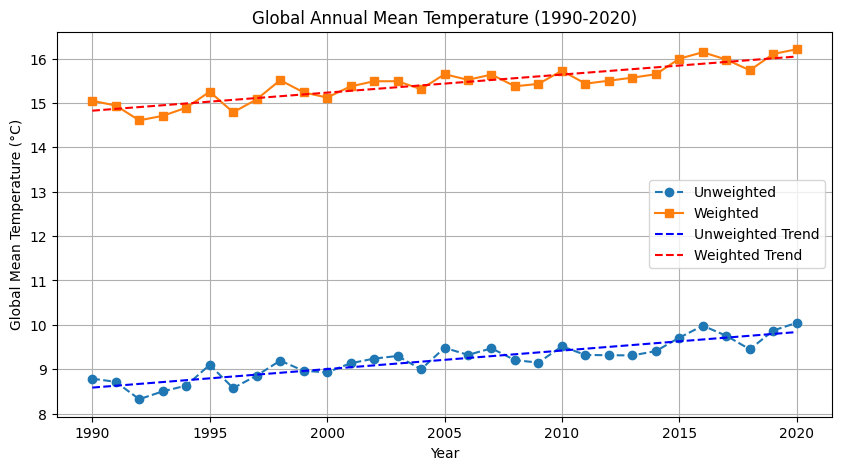

In [57]:
# plot canvas first
plt.figure(figsize=(10, 5))
# plot two mean temps
plt.plot(years, mean_TA_unweighted_annual, label="Unweighted", linestyle="--", marker="o")
plt.plot(years, mean_TA_weighted_annual, label="Weighted", linestyle="-", marker="s")
# plot trends
plt.plot(years, trend1, "b--", label="Unweighted Trend")
plt.plot(years, trend2, "r--", label="Weighted Trend")
# add labels
plt.xlabel("Year")
plt.ylabel("Global Mean Temperature (°C)")
plt.legend() # add legend
plt.title("Global Annual Mean Temperature (1990-2020)") # add title
plt.grid()
plt.show()

# Step 3: 31-year mean temperature maps

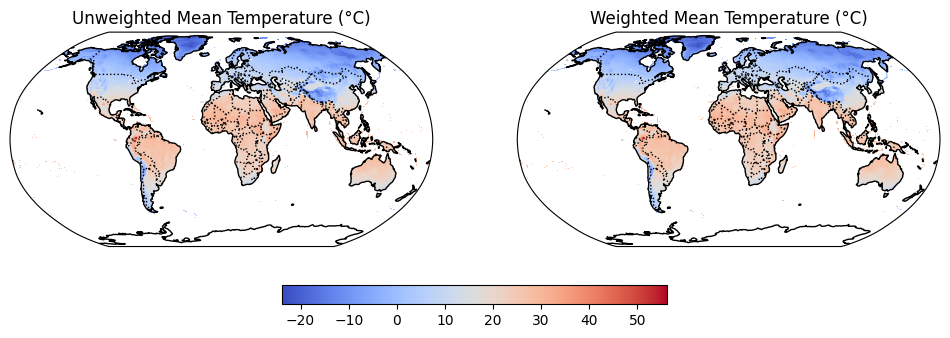

In [88]:

# compute unweighted map using mean function directly over time, keep the spatial dimensions
mean_TA_unweighted_map = TA.mean(dim="time")
# compute weighted map using xarray functions
weights = np.cos(np.deg2rad(TA.lat))
# weighted_TA = TA.weighted(weights)
# mean_TA_weighted_map = weighted_TA.mean(dim="time") # calculate mean over time
weights_2D, _ = xr.broadcast(weights, TA)  # Expands weights to match TA dimensions
weighted_TA = TA.weighted(weights_2D)  # Now the weights are correctly applied
mean_TA_weighted_map = weighted_TA.mean(dim="time")  # Compute weighted mean over time


# mean_TA_weighted_map

# plot canvas first, using Robinson projection
fig, axes = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={"projection": ccrs.Robinson()})

# loop through two maps
for ax, TA_map, title in zip(
    axes, [mean_TA_unweighted_map, mean_TA_weighted_map],
    ["Unweighted Mean Temperature (°C)", "Weighted Mean Temperature (°C)"]
):
    ax.set_global()
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    im = ax.pcolormesh(TA_map.lon, TA_map.lat, TA_map.values, cmap="coolwarm", shading="auto", transform=ccrs.PlateCarree())
    ax.set_title(title)

# add color bar
fig.colorbar(im, ax=axes, orientation="horizontal", fraction=0.05, pad=0.1)
plt.show()